# Ezgi Analizi - Temel titreşim frekans kestirimi

<a href="https://colab.research.google.com/drive/1jSlFKAiTqLXveHV6MekuzNyX8wcZzoKu?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ezgi Analizi - Temel Titreşim Frekans Kestirimi


Müzik sinyallerinde en önemli boyutlardan birisi ezgi boyutudur. İlk olarak 5. defterimizde spektrogramdan kromagram temsili elde ederek bir tür (oktav olarak katlanmış) ezgi temsili elde etmiştik. Bu defterimizde hedefimiz bir kayıt içerisinde icra edilen frekansları kestirmek (İng: estimate) için fonksiyon yazmak. Anlaşılabilir bir içerik sunabilmek için bu defterde bir anda sadece tek notanın icra edildiği (monofonik) kayıtları ele alacağız.

Önceki defterlerimizde ses sinyalinin karakteristiğinin zamanla değiştiğini ve bu nedenle sinyalimizi küçük parçalara ayırarak analiz yapmayı tercih ettiğimizi belirtmiştik. Örneğin 6. defterimizde sinyalimizi ardışık küçük kesitlere/pencerelere ayırmış ve her bir kesit için parametre (enerji, sıfır kesim oranı, spektral merkez, vb.) kestirimi gerçekleştirmiştik. Bu defterimizde de aynı şekilde sinyallerimizi küçük kesitlere ayıracak ve her küçük kesit için bir temel titreşim frekans değeri kestirmeye çalışacağız. 

Temel titreşim frekansı (İng: [fundamental frequency](https://en.wikipedia.org/wiki/Fundamental_frequency)), monofonik bir ses sinyalinden alınan bir kesitte ana dalga formunun saniyedeki tekrar sayısı olarak düşünülebilir. Kütüphanelerimizi yükleyelim ve daha sonra bir ses örneği yükleyip inceleyelim. 

In [ ]:
import os
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window
import zipfile
import urllib.request
from IPython.display import Audio

In [ ]:
# Ses verisi okuma ve Melodia aracı ile frekans kestirimi için Essentia paketinin kurulumu ve yüklenmesi
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import essentia.standard as ess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 9.4 MB/s 


İncelemek için bir dizi ses kaydı indirelim. 

In [ ]:
# UIOWA:MIS veri kümesi bağlantı adresleri
baglantilar = {
    'flute': 'http://theremin.music.uiowa.edu/sound%20files/MIS/Woodwinds/flute/flute.nonvib.ff.zip',
}

veri_klasoru = 'enstruman'
if not os.path.exists(veri_klasoru):  # klasör yok ise oluşturalım
    os.mkdir(veri_klasoru)
for enstruman, url in baglantilar.items():
    print(enstruman, 'için dosyaları indiriyor')
    hedef_klasor = os.path.join(veri_klasoru, enstruman)
    # enstrüman için altklasör yok ise oluşturalım
    if not os.path.exists(hedef_klasor):
        os.mkdir(hedef_klasor)
    dosya_ismi = url.split('/')[-1]
    urllib.request.urlretrieve(url, dosya_ismi)
    # Zip dosyasının açılması
    zip_ref = zipfile.ZipFile(dosya_ismi, 'r')
    zip_ref.extractall(hedef_klasor)
    zip_ref.close()
    os.remove(dosya_ismi)  # açılmış zip dosyasının silinmesi
    print('Veri indirildi, açıldı ve yerleştirildi: ', hedef_klasor)

flute için dosyaları indiriyor
Veri indirildi, açıldı ve yerleştirildi:  enstruman/flute


Standart nota frekanslarını da bir tablodan okuyalım.

In [ ]:
import pandas as pd # csv dosyasını okumak için pandas kütüphanesini kullanalım
nota_fr_tablo = pd.read_csv('https://github.com/barisbozkurt/dataDumpForCourses/raw/master/noteFrequencies.csv')
# Tabloyu pandas-dataFrame'den kütüphaneye dönüştürelim
nota_frekanslari = {nota_fr_tablo.iloc[ind]['notes']:nota_fr_tablo.iloc[ind]['frequencies'] for ind in range(3,nota_fr_tablo.shape[0])}
print(nota_frekanslari)

{'C0': 16.35, 'C#0': 17.32, 'Db0': 17.32, 'D0': 18.35, 'D#0': 19.45, 'Eb0': 19.45, 'E0': 20.6, 'F0': 21.83, 'F#0': 23.12, 'Gb0': 23.12, 'G0': 24.5, 'G#0': 25.96, 'Ab0': 25.96, 'A0': 27.5, 'A#0': 29.14, 'Bb0': 29.14, 'B0': 30.87, 'C1': 32.7, 'C#1': 34.65, 'Db1': 34.65, 'D1': 36.71, 'D#1': 38.89, 'Eb1': 38.89, 'E1': 41.2, 'F1': 43.65, 'F#1': 46.25, 'Gb1': 46.25, 'G1': 49.0, 'G#1': 51.91, 'Ab1': 51.91, 'A1': 55.0, 'A#1': 58.27, 'Bb1': 58.27, 'B1': 61.74, 'C2': 65.41, 'C#2': 69.3, 'Db2': 69.3, 'D2': 73.42, 'D#2': 77.78, 'Eb2': 77.78, 'E2': 82.41, 'F2': 87.31, 'F#2': 92.5, 'Gb2': 92.5, 'G2': 98.0, 'G#2': 103.83, 'Ab2': 103.83, 'A2': 110.0, 'A#2': 116.54, 'Bb2': 116.54, 'B2': 123.47, 'C3': 130.81, 'C#3': 138.59, 'Db3': 138.59, 'D3': 146.83, 'D#3': 155.56, 'Eb3': 155.56, 'E3': 164.81, 'F3': 174.61, 'F#3': 185.0, 'Gb3': 185.0, 'G3': 196.0, 'G#3': 207.65, 'Ab3': 207.65, 'A3': 220.0, 'A#3': 233.08, 'Bb3': 233.08, 'B3': 246.94, 'C4': 261.63, 'C#4': 277.18, 'Db4': 277.18, 'D4': 293.66, 'D#4': 311.

Şimdi indirdiğimiz kayıtlardan birisinin ilk notasının bir bölümünü inceleyelim. Bu kayıtta C5 ve B5 arasındaki notalar sırasıyla flüt ile icra edilmiş. İlk olarak sadece ilk 3 saniyelik kısmı kesip inceleyelim

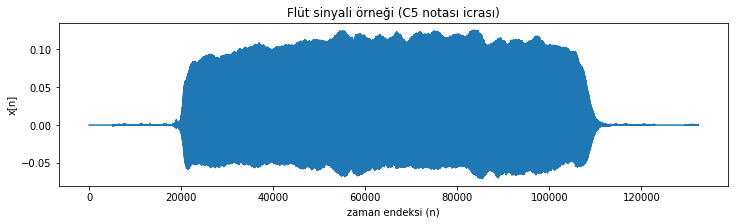

In [ ]:
ornekleme_fr = 44100
muzik_sinyali = ess.MonoLoader(filename='/content/enstruman/flute/flute.nonvib.ff.C5B5.aiff', sampleRate=ornekleme_fr)()

# Kaydın ilk 3 saniyelik bölümünü alalım, bu bölümde C5 notası icra edilmiş 
sure_saniye = 3
muzik_sinyali_3s = muzik_sinyali[:int(ornekleme_fr*sure_saniye)]

fig = plt.figure(figsize=(12,3))
plt.plot(muzik_sinyali_3s)
plt.title('Flüt sinyali örneği (C5 notası icrası)');
plt.xlabel('zaman endeksi (n)');
plt.ylabel('x[n]');
Audio(muzik_sinyali_3s, rate=ornekleme_fr)

Şekil 8.1: Tek nota icrası içeren ses sinyali dalga formu

Kaydı dinlediğinizde C5 notasını icrasını duyacaksınız.

Dalga formunu yakından görmek için sinyalin orta bölgesinden daha küçük bir kesitini inceleyelim. Değerleri orta bölgeden 500 örnek içerecek şekilde seçtik.

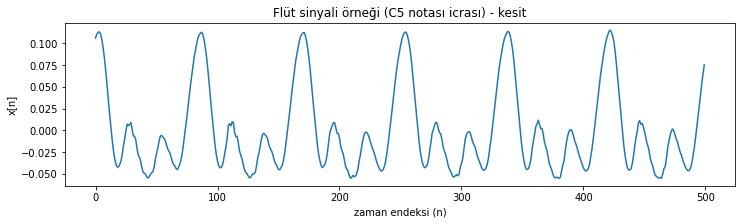

In [ ]:
baslangic_endeks = 65000
bitis_endeks = 65500
muzik_sinyali_kesit = muzik_sinyali_3s[baslangic_endeks:bitis_endeks]
fig = plt.figure(figsize=(12,3))
plt.plot(muzik_sinyali_kesit)
plt.title('Flüt sinyali örneği (C5 notası icrası) - kesit');
plt.xlabel('zaman endeksi (n)');
plt.ylabel('x[n]');
Audio(muzik_sinyali_kesit, rate=ornekleme_fr)

Şekil 8.2: Tek nota icrası içeren ses sinyali dalga formu (yakınlaştırılmış)

Şekilde bir temel dalga formunun kendini tekrarladığını görebiliyoruz. Yaklaşık bir hesapla kendini tekrar eden ana dalga formunun frekansını hesaplayalım:

Bu 500 örnekli sinyalde toplamda yaklaşık 6 periyod gözlüyoruz. Örnek sayısı cinsinden periyodumuzu yaklaşık 500/6 örnek olarak alalım. 1 saniyede 44100 örnek bulunduğu için (dosyayı okurken örnekleme frekansımızı 44100 Hz olarak seçmiştik), bu durumda 1 saniyede toplam;
44100 / (500/6) adet dalga bulunduğunu, bu sayının saniyedeki tekrar sayısı olan temel titreşim frekansına karşılık geldiğini düşünebiliriz.

In [ ]:
print("Gözleme dayalı hesaplanan temel titreşim frekansı:", 44100/(500/6), "Hz")
print("C5 notasının standart frekansı:", nota_frekanslari["C5"], "Hz")

Gözleme dayalı hesaplanan temel titreşim frekansı: 529.2 Hz
C5 notasının standart frekansı: 523.25 Hz


Gözlemle, dalga formunun uzunluğu (periyod) üzerinden, temel titreşim frekansı hesaplayabildik ve bunu icra edilen notanın frekansı ile karşılaştırarak doğrulayabildik. Peki her müzik sinyalinin analizi için bunu mu yapacağız? Elbette hayır, temel titreşim frekansını otomatik bulan fonksiyonlar yazıp kullanmayı tercih edeceğiz. Ezgi analizine başlamak için öncelikle her küçük kesit için otomatik kestirim yapabilmemiz lazım. Öncelikle bu küçük kesitteki temel titreşim frekans değişimini hazır bir kütüphane fonksiyonu yardımı ile kestirelim. 10 milisaniyede bir ölçüm yapalım ve ölçüm sonucumuzu spektrogram ile beraber çizdirelim.

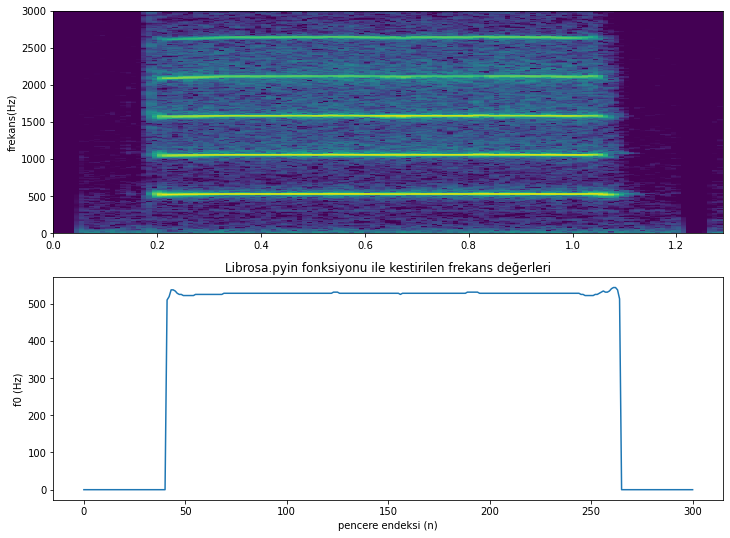

In [ ]:
pencere_kaydirma_miktari = int(0.01*ornekleme_fr) # pencere kaydırma miktarını 10 milisaniye olarak seçip örnek sayısı cinsinden ifade ettik
pencere_genisligi = pencere_kaydirma_miktari * 3 # pencere boyutumuzu da kaydırma miktarına orantılı belirleyelim: 3 kat

# Hazır fonksiyon ile temel titreşim frekansı kestirimi
f0, periyodiklik, periyodiklik_olasiligi = librosa.pyin(muzik_sinyali_3s, fmin=50, fmax=3000, sr=ornekleme_fr, win_length=pencere_genisligi, hop_length=pencere_kaydirma_miktari)

# periyodik olmayan bölgelerde kestirilen frekansları sıfırlayalım
f0[~periyodiklik] = 0

# Librosa ile spektrogram hesabı
fft_N = 4096
D = librosa.stft(muzik_sinyali_3s, n_fft=fft_N) 
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Spektrogram matrisinin çizdirilmesi
zamanEkseni = np.arange(S_db.shape[1]) * pencere_kaydirma_miktari / float(ornekleme_fr)
frekansEkseniHz = np.arange(S_db.shape[0]) * float(ornekleme_fr) / float(fft_N)


fig = plt.figure(figsize=(12,9))
plt.title('Flüt sinyali örneği (C5 notası icrası)');
plt.subplot(2,1,1)
plt.pcolormesh(zamanEkseni, frekansEkseniHz, S_db)
plt.ylim([0, 3000]) # spektrogramın 0-3000 Hz arası bölümünü görselleştirelim
plt.ylabel('frekans(Hz)');
plt.subplot(2,1,2)
plt.plot(f0)
plt.title('Librosa.pyin fonksiyonu ile kestirilen frekans değerleri');
plt.ylabel('f0 (Hz)');
plt.xlabel('pencere endeksi (n)');


Şekil 8.3: Spektrogram (yakınlaştırılmış) ve librosa.pyin fonksiyonu ile elde edilen frekans serisi

Spektrogramı, librosa.pyin fonksiyonu ile kestirilen değerler ile karşılaştırdığımızda gerçekten de kestirilen frekanslarda spektrogramda güçlü bileşenlerin bulunduğunu rahatlıkla görebiliyoruz. Peki librosa.pyin bu kestirim işlemini nasıl gerçekleştiriyor? PYIN algoritmasının detayları için [ilgili makale](https://ieeexplore.ieee.org/document/6853678)yi inceleyebilirsiniz. PYIN ve diğer birçok algoritma sinyalin kendi üzerinde kaydırılıp tekrar örtüşme noktalarının bulunması yöntemine dayanır. PYIN, sinyali kaydırılmış halinden çıkartıp farkın en düşük olduğu kaydırma miktarlarını bularak gerçekleştirir. Bu işlemin diğer alternatifi sinyali kaydırılmış haliyle çarpıp, çarpım sonucunun büyük olduğu kaydırma miktarlarını bulmaktır. Bu literatürde "otokorelasyon temelli frekans kestirimi" olarak anılır ve PYIN'in öncülü bir algoritmadır. Aşağıda bunu gerçekleştiren bir fonksiyon yazalım ve sinyalimiz üzerinde test edelim. 

Bir $x[n]$ sinyalinin otokorelasyonunu (İng:[autocorrelation](http://en.wikipedia.org/wiki/Autocorrelation)) , $r_k$, aşağıdaki gibi tanımlayabiliriz:

$$ r_k = \sum_n x[n] x[n+k] $$
Bu, temelde sinyali sinyalin $k$ örnek kaydırılmış haliyle skaler çarpımına karşılık gelir. Periyodik bir $x[n]$ sinyali için farklı $k$ değerleri ile $r_k$'yı hesaplayıp çizdirirsek periyodun tam katlarında sinyalin kaydırılmış hali kendiyle örtüşeceğinden skaler çarpımın yüksek olmasını bekleriz.

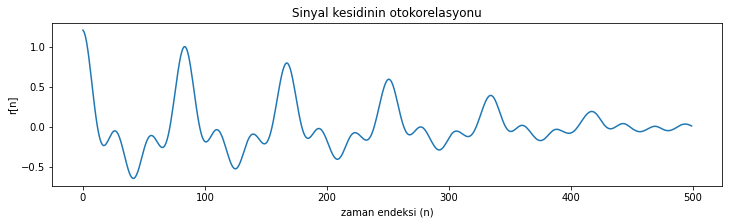

In [ ]:
def otokorelasyon(x_n):
  otokor = np.zeros_like(x_n)
  for k in range(x_n.shape[0]):
    if k==0:
      x_n_kaydirilmis = x_n
    else:
      x_n_kaydirilmis = np.hstack((np.zeros(k),x_n[:-k]))
    otokor[k] = np.dot(x_n,x_n_kaydirilmis)
  return otokor

fig = plt.figure(figsize=(12,3))
otokor_x_n = otokorelasyon(muzik_sinyali_kesit)
plt.plot(otokor_x_n);
plt.title('Sinyal kesitinin otokorelasyonu');
plt.ylabel('r[n]');
plt.xlabel('zaman endeksi (n)');

Şekil 8.4: Otokorelasyon sinyali örneği

Otokorelasyon sinyalinde periyodun tam katlarında tepeler gözlüyoruz. Otokorelasyon sinyalinin, sinyalin orijinalinden temel farkı: 0(sıfır) endeksinin ilk periyodun başı olması ve böylece sonraki periyodun başını ilk tepenin yerini bularak kestirme imkanımızın bulunması. Otokorelasyon sinyalinde 50 ve 150 örnekler arasındaki tepenin konumunu bulduğumuzda periyod bilgisine erişmiş oluruz ve periyod bilgisinden de frekansı kestirebiliriz.

In [ ]:
periyod = np.argmax(otokor_x_n[50:150]) + 50
frekans = ornekleme_fr / periyod
print("Otokorelasyon tepe noktası endeksi:", periyod)
print("Otokorelasyondan kestirilen frekans:", frekans, "Hz")

Otokorelasyon tepe noktası endeksi: 83
Otokorelasyondan kestirilen frekans: 531.3253012048193 Hz


Otokorelasyon sinyalinden frekans kestirimi yapabileceğimizi bir örnekle görmüş olduk. Otokorelasyon sinyalinde birçok tepe varolduğu için belirli bir aralıktaki tepeyi aramak işimizi kolaylaştıracaktır. Eğer maksimum periyod ve minimum periyod için bir öngörümüz var ise bu aralıktaki tepeyi aramamız yeterli olacaktır. Çoğunlukla örnek sayısı cinsinden periyod yerine minimum frekans ve maksimum frekans için öngörümüz vardır ve periyod bilgisini de frekans bilgisinden elde edebiliriz. Örneğin elimizdeki sinyal bir konuşma sinyali ise sinyalin frekansının 60 Hz-500 Hz arasında olduğunu varsayarak ilerleyebiliriz. Aşağıda sunulan, minimum ve maksimum frekans öngörüsünü kullanarak frekans kestirim yapan fonksiyonu inceleyiniz:

In [ ]:
def frekans_kestir_otokorelasyon(x_n, ornekleme_fr, minF0, maxF0):
    '''Otokorelasyon yöntemi ile frekans kestirimi
    Parametreler
    ----------
    x_n : numpy.array
        Sinyal kesiti
    ornekleme_fr,minF0,maxF0 : float/int
        Örnekleme frekansı, minimum ve maksimum frekans değerleri
        
    Çıktı
    -------
    f0 : float
        Kestirien frekans (Hz) 
    ''' 
    f0 = 0
    # Ilk olarak limitleri frekanstan periyod bilgisine dönüştürelim
    minT0 = int(ornekleme_fr/maxF0)
    maxT0 = int(ornekleme_fr/minF0)
    # minT0-maxT0 arasındaki kaydırma değerlerinde otokorelasyonun 
    #  en yüksek değer aldığı kaydırma miktarını bulmayı hedefliyoruz 
    max_deger = -1;T0 = -1
    for k in range(minT0, maxT0):
        x_n_kaymis = np.hstack((np.zeros(k),x_n[:-k]))
        otokor_k = np.dot(x_n,x_n_kaymis)
        if otokor_k > max_deger:
            T0 = k
            max_deger = otokor_k
    # T0 değişkeni maksimum noktanın endeksini içeriyor, örnek sayısı cinsinden 
    # periyod bilgisine karşılık geliyor, frekansa dönüştürelim 
    f0 = float(ornekleme_fr) / T0
    return f0

Şimdi fonksiyonumuzu C5 notasını icra eden flüt kaydı üzerinde test edelim.

In [ ]:
minF0 = 50 # Hz cinsinden beklenen en düşük frekans 
maxF0 = 2000 # Hz cinsinden beklenen en yüksek frekans
pencere_genisligi = 4096
pencere_kaydirma_miktari = 1024
w = get_window('blackman', pencere_genisligi)
baslangic_noktalari = np.arange(0, muzik_sinyali_3s.size - pencere_genisligi, pencere_kaydirma_miktari, dtype = int)
pencere_sayisi = baslangic_noktalari.size

In [ ]:
# Sinyali kesit/pencerelere bölüp her bir pencere için frekans kestirimi yapalım
f0 = np.zeros_like(baslangic_noktalari,dtype=float) 
for k in range(pencere_sayisi):
    x_n = muzik_sinyali_3s[baslangic_noktalari[k] : baslangic_noktalari[k] + pencere_genisligi] * w # pencereleme işlemi
    f0[k] = frekans_kestir_otokorelasyon(x_n, ornekleme_fr, minF0, maxF0)

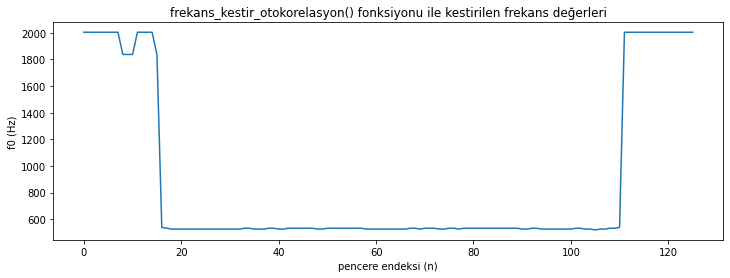

In [ ]:
# Kestirilen frekans değerlerini çizdirelim
fig = plt.figure(figsize=(12,4))
plt.title('Flüt sinyali örneği (C5 notası icrası)');
plt.plot(f0)
plt.title('frekans_kestir_otokorelasyon() fonksiyonu ile kestirilen frekans değerleri');
plt.ylabel('f0 (Hz)');
plt.xlabel('pencere endeksi (n)');

Şekil 8.5: Otokorelasyon yöntemi ile elde edilen frekans serisi

Kaydın iki kenarında sessizlik var. O bölgelerdeki değerleri sıfırlayabiliriz. Bunu enerji parametresini kullanarak gerçekleştirelim. Enerjinin maksimum enerjinin %5'inin altına düştüğü pencereleri sessiz bölgeler olarak ele alacağız.

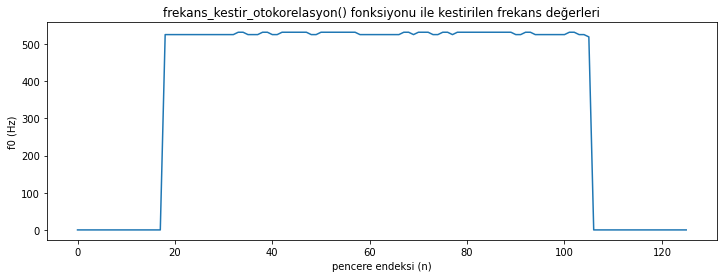

In [ ]:
# Enerji hesabı 
NRG = np.zeros_like(f0,dtype = float)
for k in range(pencere_sayisi):
    x_n = muzik_sinyali_3s[baslangic_noktalari[k]:baslangic_noktalari[k] + pencere_genisligi] * w
    NRG[k] = np.sum(np.power(x_n,2))

# Enerjinin maksimumunun %5'i altındaki bölgelerde frekans değerlerinin sıfırlanması
esik_deger_oran = 0.05
f0[NRG < np.max(NRG)*esik_deger_oran] = 0

# Kestirilen frekans değerlerini çizdirelim
fig = plt.figure(figsize=(12,4))
plt.title('Flüt sinyali örneği (C5 notası icrası)');
plt.plot(f0)
plt.title('frekans_kestir_otokorelasyon() fonksiyonu ile kestirilen frekans değerleri');
plt.ylabel('f0 (Hz)');
plt.xlabel('pencere endeksi (n)');

Şekil 8.6: Otokorelasyon yöntemi ile elde edilen frekans serisi (sinyalin enerjisi düşük bölgelerinde frekans sıfırlandıktan sonra)

Şimdi kendi yazdığımız fonksiyon ve librosa.pyin fonksiyonu ile sinyalin tümü üzerinde frekans kestirimi yapıp sonuçları karşılaştıralım.

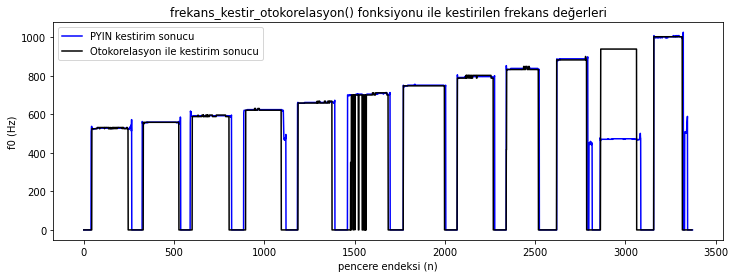

In [ ]:
pencere_kaydirma_miktari = int(0.01*ornekleme_fr) # pencere kaydırma miktarını 10 milisaniye olarak seçip örnek sayısı cinsinden ifade ettik
pencere_genisligi = pencere_kaydirma_miktari * 3 # pencere boyutumuzu da kaydırma miktarına orantılı belirleyelim: 3 kat
minF0 = 50 # minimum frekans
maxF0 = 2000 # maximum frekans

# Librosa.pyin hazır fonksiyonu ile temel titreşim frekansı kestirimi
f0_pyin, periyodiklik, periyodiklik_olasiligi = librosa.pyin(muzik_sinyali, fmin=minF0, fmax=maxF0, sr=ornekleme_fr, win_length=pencere_genisligi, hop_length=pencere_kaydirma_miktari)

# periyodik olmayan bölgelerde kestirilen frekansları sıfırlayalım
f0_pyin[~periyodiklik] = 0

# Otokorelasyon temelli frekans kestirimi
w = get_window('blackman', pencere_genisligi)
baslangic_noktalari = np.arange(0, muzik_sinyali.size - pencere_genisligi, pencere_kaydirma_miktari, dtype = int)
pencere_sayisi = baslangic_noktalari.size
f0_otokor = np.zeros_like(baslangic_noktalari,dtype=float)
NRG = np.zeros_like(f0_otokor, dtype = float)
for k in range(pencere_sayisi): 
    x_n = muzik_sinyali[baslangic_noktalari[k] : baslangic_noktalari[k] + pencere_genisligi] * w # pencereleme işlemi
    f0_otokor[k] = frekans_kestir_otokorelasyon(x_n, ornekleme_fr, minF0, maxF0)
    NRG[k] = np.sum(np.power(x_n,2))

esik_deger_oran = 0.05
f0_otokor[NRG < np.max(NRG)*esik_deger_oran] = 0

# Ölçülen frekans değerlerinin üstüste çizdirilmesi
fig = plt.figure(figsize=(12,4))
plt.title('Flüt sinyali örneği');
plt.plot(f0_pyin,'b', label='PYIN kestirim sonucu')
plt.plot(f0_otokor,'k', label='Otokorelasyon ile kestirim sonucu')
plt.title('frekans_kestir_otokorelasyon() fonksiyonu ile kestirilen frekans değerleri');
plt.ylabel('f0 (Hz)');
plt.xlabel('pencere endeksi (n)');
plt.legend();

Şekil 8.7: Librosa.pyin ve otokorelasyon yöntemi ile elde edilen frekans serileri

Sonuçların birçok noktada örtüştüğünü, pyin'in sondan önceki notada frekansı yarısı değerinde kestirdiğini (oktav hatası yaptığını) görebiliyoruz. Oktav hatası (frekansı doğru değerinden *$2^k$ farklı olarak tespit etmek, $k$ tamsayı) yapılan en tipik hatalardandır. 

### Frekans kestirim algoritmasının test edilmesi

Peki, yapılan frekans kestirim sonucunun doğruluğunu nasıl ölçebiliriz? Elimizdeki veriler sentetik değilse gerçek frekans değerinden emin olmamız mümkün değildir. Ancak başka özniteliklerle (örneğin spektrogram ile) karşılaştırmak veya elle işaretlemesi yapılmış veriler üzerinden standart testler gerçekleştirmek şeklinde opsiyonlarımız bulunmakta. Bu örnek için spektrogram ile beraber çizdirerek karşılaştırmaya bir örnek görelim. 

#### Başka özniteliklerle (örneğin spektrogram ile) karşılaştırmak

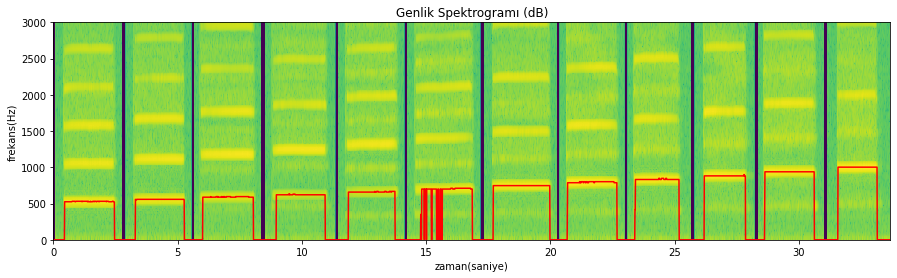

In [ ]:
fft_N = 4096
spktrgrm = np.array([]).reshape(0, int(fft_N / 2)) # spektogram boş bir dizi olarak başlatılıyor
for k in range(pencere_sayisi):
    pencere_baslangici = baslangic_noktalari[k]
    x_w = muzik_sinyali[pencere_baslangici:pencere_baslangici + pencere_genisligi] * w
    X = np.fft.fft(x_w, fft_N)
    genlikX = np.abs(X[:int(fft_N / 2)])
    genlikX[genlikX < np.finfo(float).eps] = np.finfo(float).eps # log operasyonundan önce önlem
    genlik_spektrumu = 20 * np.log10(genlikX)
    spktrgrm = np.vstack((spktrgrm, genlik_spektrumu)) # k. sinyal kesitinin spektrumunun eklenmesi

# Spektrogram matrisinin çizdirilmesi
zamanEkseni = np.arange(spktrgrm.shape[0]) * pencere_kaydirma_miktari / float(ornekleme_fr)
frekansEkseniHz = np.arange(spktrgrm.shape[1]) * float(ornekleme_fr) / float(fft_N)

fig = plt.figure(figsize=(15,4))
plt.pcolormesh(zamanEkseni, frekansEkseniHz, np.transpose(spktrgrm))
plt.plot(zamanEkseni, f0_otokor,'r', label='Otokorelasyon ile kestirim sonucu')
plt.ylim([0, 3000]) # spektrogramın 0-3000 Hz arası bölümünü görselleştirelim
plt.title('Genlik Spektrogramı (dB)')
plt.ylabel('frekans(Hz)')
plt.xlabel('zaman(saniye)')
plt.show()

Şekil 8.8: Spektrogram ve otokorelasyon yöntemi ile elde edilen frekans serisi

Spektrogramla kestirilen frekans değerlerini üstüste çizdirdiğimizde temel titreşim frekans değerlerinin spektrogramda 1. harmonik izi ile örtüştüğünü doğrulayabiliyoruz. 15. saniye civarında yanlış kestirim yapılmış pencereler olduğu da görülebiliyor.

#### Çeşitli yöntemlerin standart metrikler kullanılarak test edilmesi



Birden fazla algoritmanın kestirdiği temel titreşim frekans değerlerini, hangisinin daha iyi sonuç verdiğini anlamak için, karşılaştırmamız gerekirse bu alanda kullanılan standart test yöntemlerini kullanmamızda fayda var. Aşağıda güncel olarak kullanılan, başarım seviyesi yüksek 3 ayrı kütüphanenin standart veri ve test yöntemi ile karşılaştırılmasına yönelik kod örneği bulabilirsiniz. 

Burada şu noktaları gözden kaçırmamak gerekir: 

*   Her bir algoritma için bir dizi parametre bulunmaktadır ve parametre seçimi başarı düzeyini etkileyecektir. Çeşitli parametre kombinasyonları ile testler yapıp en iyi kombinasyonları elde ettikten sonra karşılaştırma yapmak daha güvenilir bir karşılaştırma sonucu sunacaktır
*   Algoritmaların farklı ses örneklerinde başarı düzeyleri farklı olacaktır. Tekil örneklerden yola çıkarak sonuca varmak yerine çok sayıda ve farklı türde veriler üzerinde test yapıp raporlamak faydalı olacaktır
*   Frekans kestirim sonuçlarındaki bazı hatalar (örneğin oktav hataları) kural tabanlı işlemlerle düzeltilebilmektedir. Uygulama geliştirirken bu olasılık da değerlendirilmelidir. 



Testlerimizde verilere erişim ve test fonksiyonları için şu kütüphaneleri kullanacağız:

*   [mirdata](https://github.com/mir-dataset-loaders/mirdata): müzik bilgi erişim alanında kullanılan bazı veri kümelerinin kolayca yüklenmesini sağlar
*   [mir_eval](https://github.com/craffel/mir_eval): müzik bilgi erişim alanında standart kalite testleri gerçekleştirmek için kullanılan bir kütüphane   

Ayrıca frekans kestirim için güncel tekniklerden birisi olan Crepe algoritmasını da testlerimize dahil edeceğiz. 

In [ ]:
!pip install crepe mir_eval mirdata
import mirdata, mir_eval, crepe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 5.2 MB/s 
     |████████████████████████████████| 13.1 MB 41.0 MB/s 
     |████████████████████████████████| 323 kB 49.7 MB/s 
     |████████████████████████████████| 129 kB 43.1 MB/s 
     |████████████████████████████████| 5.6 MB 48.3 MB/s 
     |████████████████████████████████| 51 kB 85 kB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
  Created wheel for crepe: filename=crepe-0.0.12-py3-none-any.whl size=134848696 sha256=dd0771d7f13d72d7133e4f813a5e4957ea767e5918b5412138f5646871eab606
  Stored in directory: /root/.cache/pip/wheels/56/05/32/fccf64e8ae720b34b486b6a8a08712777fd0beab419980fea3
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320732 sha256=b9ce4d365b1facbd44c7909aba6541bd219c4c0dc4c4ed2fcc8161533eddc21b
  Stored in directory: /root/.cache/pip/wheels/a0/18/0a/8ad18a597d8333a142c9789338a96a62

mirdata aracılığıyla erişilebilen veri kümelerinin listesi için [bakınız](https://mirdata.readthedocs.io/en/stable/source/quick_reference.html). Listelenen veriler içerisinde F0 etiketleri içerenlerden birisi olan "vocadito"yu kullanacağız.


In [ ]:
# Verilerin indirilmesi
vocadito = mirdata.initialize('vocadito')
vocadito.download()
# İndirilen verilerdeki dosya bilgilerinin yüklenmesi
dosyalar = vocadito.load_tracks()

55.8MB [01:56, 501kB/s]                            


In [ ]:
# Analiz parametrelerinin belirlenmesi 
ornekleme_fr = 44100
pencere_kaydirma_miktari = int(0.005*ornekleme_fr)
pencere_genisligi = pencere_kaydirma_miktari * 6
minF0 = 50
maxF0 = 500 # vokal örneği üzerinde kestirim yapacağımız için üst limiti düşük tutabiliriz

Aşağıdaki kod bir ses dosyası için üç algoritmanın frekans kestirim sonuçlarının karşılaştırmasını gerçekleştirir. Çalıştırıp sonucu aldıktan sonra isterseniz ilk satırı değiştirip analizi tüm veriler üzerinde işletebilirsiniz. 

In [ ]:
# for dosya_ismi in dosyalar.keys(): # veri kümesindeki tüm dosyalar için test yapmak isterseniz bir alttaki yerine bu satırı kullanabilirsiniz
for dosya_ismi in ['1']: # listeye isterseniz başka örneklerin endekslerini (virgülle ayırarak) ekleyebilirsiniz
  dosya = dosyalar[dosya_ismi]
  print('Ses dosyası konumu:', dosya.audio_path)
  print('Etiket dosyası konumu:', dosya.f0_path)
  # Ses dosyasının okunması
  x = ess.MonoLoader(filename = dosya.audio_path, sampleRate = ornekleme_fr)()
  
  # Melodia ile temel titreşim frekans kestirimi
  frekans_serisi_melodia, guvenilirlik = ess.PitchMelodia(guessUnvoiced = True, 
                                                  frameSize = int(pencere_genisligi), 
                                                  hopSize = pencere_kaydirma_miktari,
                                                  maxFrequency = maxF0,
                                                  sampleRate=ornekleme_fr)(x)
  # Güvenilirliğin düşük olduğu kestirimleri sıfırlayalım
  frekans_serisi_melodia[guvenilirlik <= 0.0] = 0
  zaman_serisi_melodia = np.linspace(0, x.size/ornekleme_fr, num=frekans_serisi_melodia.size, endpoint=False) 

  # Crepe ile temel titreşim frekans kestirimi
  print('Crepe frekans kestirim işlemi gerçekleştiriliyor')
  zaman_serisi_crepe, frekans_serisi_crepe, guvenilirlik, activation = crepe.predict(x, ornekleme_fr, viterbi=True)
  # Güvenilirliğin düşük olduğu kestirimleri sıfırlayalım
  frekans_serisi_crepe[guvenilirlik < 0.5] = 0

  # Librosa.pyin ile temel titreşim frekans kestirimi
  print('Pyin frekans kestirim işlemi gerçekleştiriliyor')
  frekans_serisi_pyin, periyodiklik, periyodiklik_olasiligi = librosa.pyin(x, fmin=minF0, fmax=maxF0, sr=ornekleme_fr, win_length=pencere_genisligi, hop_length=pencere_kaydirma_miktari)
  zaman_serisi_pyin = np.linspace(0, x.size/ornekleme_fr, num=frekans_serisi_pyin.size, endpoint=False) 

  # Veri etiketlerinin (doğru değerlerin) okunması
  zaman_serisi_referans, frekans_serisi_referans = mir_eval.io.load_time_series(dosya.f0_path, delimiter=',')

  # Gerçek değerleri ile kestirilen değerlerin karşılaştırılması 
  sonuclar_melodia = mir_eval.melody.evaluate(zaman_serisi_referans, frekans_serisi_referans, zaman_serisi_melodia, frekans_serisi_melodia)
  sonuclar_crepe = mir_eval.melody.evaluate(zaman_serisi_referans, frekans_serisi_referans, zaman_serisi_crepe, frekans_serisi_crepe)
  sonuclar_pyin = mir_eval.melody.evaluate(zaman_serisi_referans, frekans_serisi_referans, zaman_serisi_pyin, frekans_serisi_pyin)
  
  for sonuclar, algoritma in zip([sonuclar_melodia, sonuclar_crepe, sonuclar_pyin],['melodia', 'crepe', 'pyin']):
    print('----------------------')
    print(algoritma, 'algoritması için sonuçlar:')
    for anahtar, deger in sonuclar.items():
      print(anahtar, deger)

Ses dosyası konumu: /root/mir_datasets/vocadito/Audio/vocadito_1.wav
Etiket dosyası konumu: /root/mir_datasets/vocadito/Annotations/F0/vocadito_1_f0.csv
Crepe frekans kestirim işlemi gerçekleştiriliyor
104/104 [==============================] - 161s 2s/step
Pyin frekans kestirim işlemi gerçekleştiriliyor
----------------------
melodia algoritması için sonuçlar:
Voicing Recall 0.899505766062603
Voicing False Alarm 0.26009615384615387
Raw Pitch Accuracy 0.8833058758923669
Raw Chroma Accuracy 0.8833058758923669
Overall Accuracy 0.8311779098217407
----------------------
crepe algoritması için sonuçlar:
Voicing Recall 0.9879187259747392
Voicing False Alarm 0.08798076923076924
Raw Pitch Accuracy 0.9829763866007688
Raw Chroma Accuracy 0.9829763866007688
Overall Accuracy 0.9571828032156589
----------------------
pyin algoritması için sonuçlar:
Voicing Recall 0.9925864909390445
Voicing False Alarm 0.14951923076923077
Raw Pitch Accuracy 0.9827018121911038
Raw Chroma Accuracy 0.9827018121911038
O

Testlerde kullanılan başarı ölçütlerine dair açıklamalar için bakınız:

*   [Voicing measures](http://craffel.github.io/mir_eval/#mir_eval.melody.voicing_measures)
*   [Raw pitch accuracy](https://craffel.github.io/mir_eval/#mir_eval.melody.raw_pitch_accuracy)
*   [Raw chroma accuracy](http://craffel.github.io/mir_eval/#mir_eval.melody.raw_chroma_accuracy)
*   [Overall accuracy](http://craffel.github.io/mir_eval/#mir_eval.melody.overall_accuracy)





Bu örnekte Crepe algoritmasının başarı düzeyinin diğer algoritmalardan yüksek olduğunu görebiliyoruz.

Son olarak frekans serilerini görsel olarak karşılaştırabiliriz. Değerler birbirine çok yakın olduğu için serileri y ekseninde kaydırarak çizdirmeyi tercih edeceğiz.

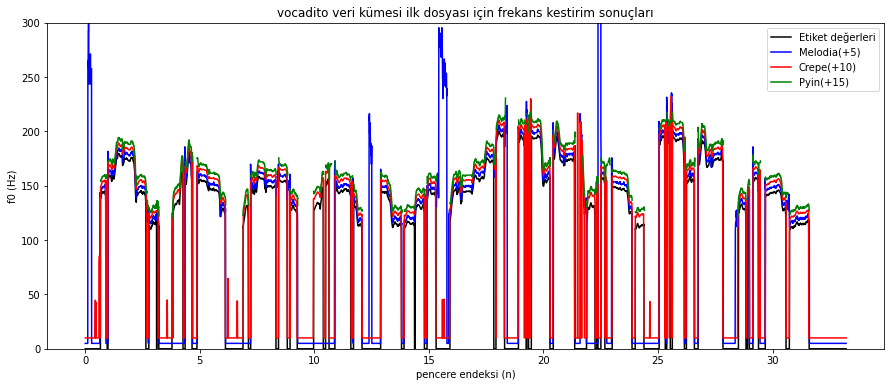

In [ ]:
# Ölçülen frekans değerlerinin üstüste çizdirilmesi
kaydirma_miktari = 5
fig = plt.figure(figsize=(15,6))
plt.title('vocadito veri kümesi ilk dosyası için frekans kestirim sonuçları');
plt.plot(zaman_serisi_referans, frekans_serisi_referans, 'k', label='Etiket değerleri')
plt.plot(zaman_serisi_melodia, frekans_serisi_melodia+kaydirma_miktari, 'b', label='Melodia(+{})'.format(kaydirma_miktari))
plt.plot(zaman_serisi_crepe, frekans_serisi_crepe+2*kaydirma_miktari, 'r', label='Crepe(+{})'.format(2*kaydirma_miktari))
plt.plot(zaman_serisi_pyin, frekans_serisi_pyin+3*kaydirma_miktari, 'g', label='Pyin(+{})'.format(3*kaydirma_miktari))
plt.ylabel('f0 (Hz)');
plt.xlabel('pencere endeksi (n)');
plt.ylim(0, 300)
plt.legend();

Şekil 8.9: Vocadito veri kümesi ilk örneği için Melodia, Crepe ve Librosa.pyin ile elde edilen frekans serileri ve etiket değerleri

Bu örnek için, test ettiğimiz üç algoritma ile de gerçek etiket değerlerine çok yakın değerler elde ettiğimizi grafikten görebiliyoruz. En açık hatalar: Melodia bazı sessiz bölgelerde frekans değerleri döndürmüş. Muhtemelen bu hatalar yukarıda yaptığımız gibi enerjisi düşük bölgelerde frekans sıfırlanarak düzeltilebilir. Vokal kayıtlarının çoğu için benzer sonuçları bekleyebiliriz. 

Bu defterimizde verili bir ses kaydında icra edilen frekans serisini kestirme konusunu ele aldık. Hem kendimiz bir fonksiyon yazdık, hem de güncel hazır araçların kullanımını örnekledik. Sonraki defterde frekans serisinin işlenmesine yönelik örnekler göreceğiz. 

**Yazar:** Barış Bozkurt, **editör:** Ahmet Uysal

---

